Instalacja potrzebnego oprogramowania do poprawnego działania modułów przetrzennych w pythonie

In [ ]:
!apt install libspatialindex-dev 
!pip install -U pysal urbanaccess pandana
!pip install libpysal esda

In [47]:
import numpy as np ## macierze itp 
import pandas as pd  ## ramki danych
import geopandas as gpd ## ramki danych z atrybutami przestrzennymi
import libpysal as ps ## macierze, miary Morana itp
import esda
import matplotlib.pyplot as plt ## do wykresów
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 10] ## wielkosc wykresów
from splot.esda import moran_scatterplot ## wykres rozrzutu dla statystyk morana
from splot.esda import lisa_cluster ## pozwoli nam nanieść wyniki na mapę

In [3]:
pow_df = gpd.read_file("powiaty.shp", encoding='utf-8') ## (sh)ape (p)olygon file
pow_df = pow_df[["SP_ID", "jpt_kod_je", "jpt_nazwa_", "geometry"]]
pow_df.head(n=2)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry
0,0,0226,powiat złotoryjski,"POLYGON ((269083.616 370884.075, 269164.192 37..."
1,1,0262,powiat Legnica,"POLYGON ((296226.609 372333.783, 296689.158 37..."


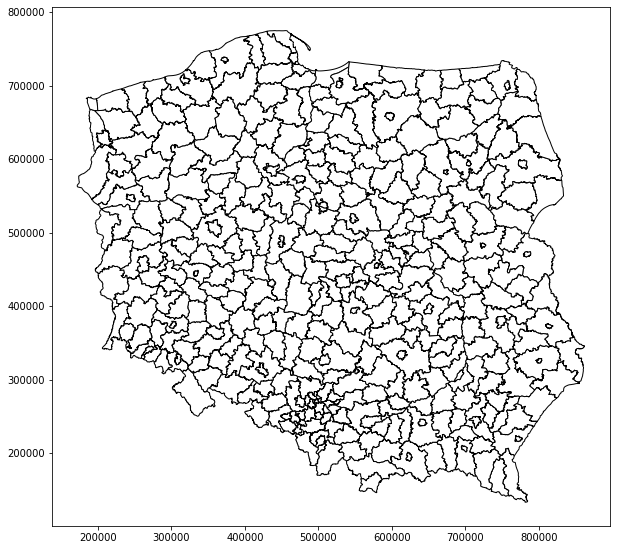

In [4]:
pow_df.plot(color = "white", edgecolor = "black")

Wczytujemy dane dotyczące wynagrodzeń

In [5]:
pow_wynagrodzenia = pd.read_excel("powiaty_wynag.xlsx", sheet_name = 1)
pow_wynagrodzenia = pow_wynagrodzenia[["Kod", "Wartosc"]]
pow_wynagrodzenia["kod_4"] = pow_wynagrodzenia.Kod.astype(str).str.zfill(7)
pow_wynagrodzenia["kod_4"] = pow_wynagrodzenia.kod_4.str.slice(0,4)
pow_wynagrodzenia.drop("Kod", axis= 1, inplace = True)
pow_wynagrodzenia.head()

,Wartosc,kod_4
0,4214.66,0201
1,4024.94,0202
2,4077.69,0203
3,3815.89,0204
4,4029.64,0205


Dołączamy do zbioru z mapami informację o poziomie wynagrodzeń 

In [6]:
dane_analiza = pd.merge(left = pow_df, right = pow_wynagrodzenia, how = "left", left_on = "jpt_kod_je", right_on= "kod_4")
dane_analiza.head()

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry,Wartosc,kod_4
0,0,0226,powiat złotoryjski,"POLYGON ((269083.616 370884.075, 269164.192 37...",4362.98,0226
1,1,0262,powiat Legnica,"POLYGON ((296226.609 372333.783, 296689.158 37...",4259.37,0262
2,2,0206,powiat jeleniogórski,"POLYGON ((244044.051 332419.671, 244238.860 33...",4035.56,0206
3,3,0204,powiat górowski,"POLYGON ((311163.070 427025.480, 311278.286 42...",3815.89,0204
4,4,0214,powiat oleśnicki,"POLYGON ((377122.144 378970.426, 377400.754 37...",4128.29,0214


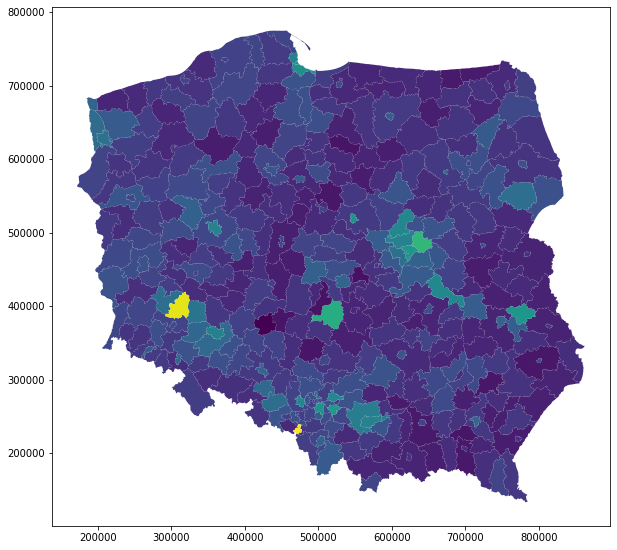

In [9]:
dane_analiza.plot(column = "Wartosc")

In [ ]:
dane_analiza.sort_values(by = "Wartosc", ascending=False)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry,Wartosc,kod_4
276,276,2467,powiat Jastrzębie-Zdrój,"POLYGON ((465163.252 230038.515, 465227.497 23...",8121.08,2467
28,28,0211,powiat lubiński,"POLYGON ((291305.112 387732.614, 291371.123 38...",7915.01,0211
143,143,1465,powiat Warszawa,"POLYGON ((626505.916 483271.600, 626528.812 48...",6432.78,1465
63,63,1001,powiat bełchatowski,"POLYGON ((489945.770 380441.322, 492229.268 38...",6259.40,1001
286,286,2468,powiat Jaworzno,"POLYGON ((511468.719 262151.768, 511569.976 26...",5848.34,2468
...,...,...,...,...,...,...
57,57,1018,powiat wieruszowski,"POLYGON ((435569.180 387437.039, 435802.098 38...",3454.23,1018
323,323,2812,powiat nowomiejski,"POLYGON ((512548.856 627427.390, 512705.072 62...",3439.34,2812
65,65,1003,powiat łaski,"POLYGON ((486303.072 393604.387, 486333.093 39...",3432.41,1003
59,59,1021,powiat brzeziński,"POLYGON ((544478.277 432502.163, 546511.433 43...",3385.89,1021


Analiza przetrzenna z wykorzystaniem miary autokorelacji przetrzennej Moran'a -- wersja globalna i lokalna

https://github.com/DepartmentOfStatisticsPUE/air-2020/blob/master/notebooks/10_analizy_przetrzenne.ipynb


Wyznaczamy macierz sąsiedztwa

In [10]:
W = ps.weights.Queen.from_dataframe(dane_analiza)
W.full()[0]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
W.transform = 'r' ## standaryzacja według wierszy
W.full()[0][:5,:5]

array([[0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ]])

In [12]:
mi = esda.moran.Moran(dane_analiza.Wartosc, W)
mi.I ## autokorelacja jest dodatnia - im wyższe wartości tym autokorelacja jest silniejsza

0.23194481829022168

Układ hipotez w testowaniu autokorelacji I Moran'a przestrzennej jest następujący

$$
\begin{align}
H_0:& I = 0 \\
H_1:& I \neq 0
\end{align}
$$

Jeżeli p-value < 0.05 to odrzucamy hipotezę zerową na rzecz laternatywnej. Ponieważ zwykle w ekonomii przyjmujemy poziom $\alpha=0.05$.

In [13]:
mi.p_norm

6.1948224328034485e-12

Wyliczamy miary lokalne I Moran'a z wykorzystaniem funkcji `esda.moran.Moran_Local`

In [16]:
mi_local = esda.moran.Moran_Local(dane_analiza.Wartosc, W)
mi_local.Is[1:10]

array([ 0.01608459, -0.01296047, -0.58257366,  0.00441351,  0.01487871,
       -0.13632716,  0.066761  ,  0.00770085, -0.07764274])

In [20]:
np.mean(mi_local.Is)

0.23133443718945804

In [21]:
np.std(mi_local.Is)

0.7269806009398164

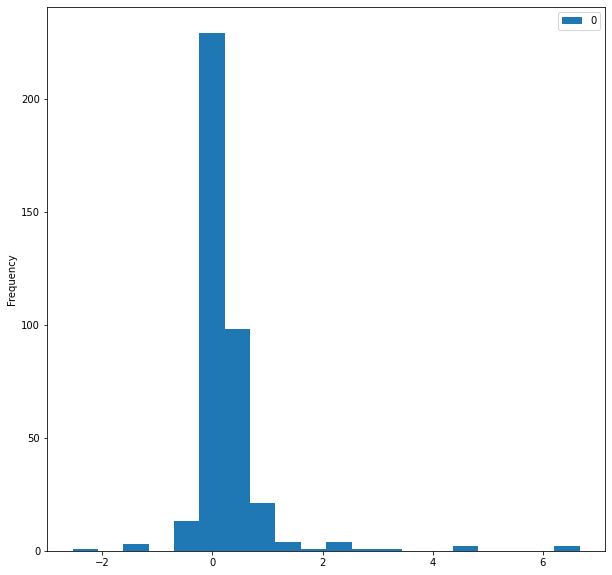

In [46]:
dane_analiza.moran = pd.DataFrame(mi_local.Is)
dane_analiza.moran.plot.hist(bins = 20)

Tworzymy wykres rozrzutu lokalnej statystyki I Moran'a, który określa układ jednostek w następujacy sposób:

+ HH (prawa górna ćwiartka, high-high) -- jednostki, które mają wysokie wynagrodzenia i są otoczone jednostkami o wysokich wyngarodzeniach,
+ LL (lewa dolna ćwiartka, low-low) -- jednostki, które mają niskie wynagrodzenia i są otoczone jednostkami o niskich wynagrodzeniach,
+ LH (lewa górna ćwiartka, low-high) -- jednostki, które mają niskie wynagrodzenia ale są otoczone powiatami o wysokich wynagrodzeniach,
+ HL (prawa dolna ćwiartka, high-low) -- jednostki o wysokich wynagrodzeniach ale otoczone powiatami o niskich wynagrodzeniach.



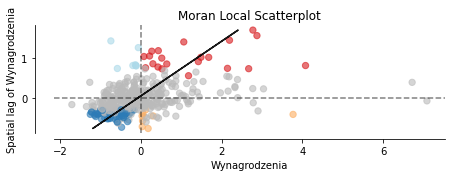

In [53]:
fig, ax = moran_scatterplot(mi_local, p=0.05)
ax.set_xlabel("Wynagrodzenia")
ax.set_ylabel("Spatial lag of Wynagrodzenia")
plt.show()

Interpretacja wyników:

1. powiaty HH:
    + Gdynia, Sopot, Gdańsk; 
    + Warszawa, otwocki, piaseczyński, pruszkwowski, grodziski, powiat warszawski zachodni, legionowski
    + wołoski, średzki, świdnicki, legnicki, polkowicki
2. powiaty HL - wysokie wartości ale otoczone niskimi wartościami:
    + powiat bydgoski
    + powiat wąbrzeski 
    + powiat m. Włocławek
3. powiaty LH - niskie wartości otoczone wysokimi wartościami:
    + cieszyński
    + pszyczyński
    + raciborski
    + myszkowski

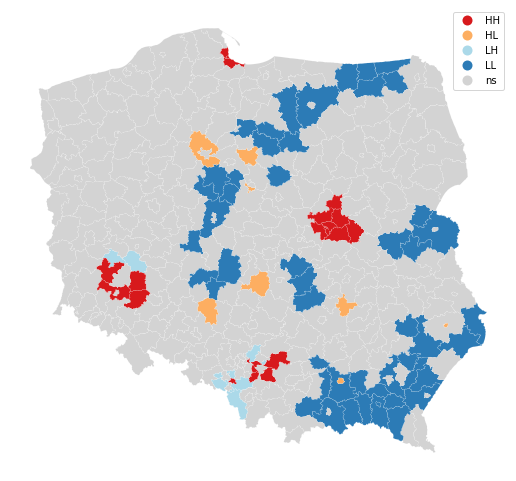

In [56]:
lisa_cluster(mi_local, dane_analiza, p = 0.05, figsize = (9,9))
plt.show()

Aby dowiedzieć się, które powiaty są w której ćwirtce (HH, LL, HL, LH) możemy podejrzeć wartości w `mi_local.q`:

+ 1 - HH -- wysokie z wysokimi
+ 2 - LH -- coldspots
+ 3 - LL -- niskie z niskimi
+ 4 - HL -- hotspots

In [75]:
dane_analiza["klasa"] = pd.DataFrame(mi_local.q)
dane_analiza[["klasa", "jpt_nazwa_"]]
dane_analiza.klasa.value_counts(ascending=True)

2     58
4     67
1     82
3    173
dtype: int64